In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot

class PolicyNet(nn.Module) :
    def __init__(self, state_dim, hidden_dim, action_dim) :
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim, dtype=torch.float64)
        self.fc2 = nn.Linear(hidden_dim, action_dim, dtype=torch.float64)
        
    def forward(self, x) :
        l1 = self.fc1(x)
        a1 = F.relu(l1)
        l2 = self.fc2(a1)
        a2 = F.softmax(l2, dim=1)
        #print('x:',x.shape, "l1:", l1.shape, "a1:", a1.shape, "l2:", l2.shape, "a2:", a2.shape)
        return a2

class StateValueNet(nn.Module) :
    def __init__(self, state_dim, hidden_dim) :
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim, dtype=torch.float64)
        self.fc2 = nn.Linear(hidden_dim, 1, dtype=torch.float64)
        
    def forward(self, x) :
        l1 = self.fc1(x)
        a1 = F.relu(l1)
        l2 = self.fc2(a1)
        #print('x:',x.shape, "l1:", l1.shape, "a1:", a1.shape, "l2:", l2.shape, "a2:", a2.shape)
        return l2

import numpy as np

class Agent() :
    def __init__(self, state_dim, hidden_dim, action_dim, gamma, device) :
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # optimizer, lr,
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=0.0001)

        self.value_net = StateValueNet(state_dim, hidden_dim).to(device)
        self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=0.001)
        self.loss = nn.MSELoss()

        self.gamma = gamma

        self.device = device

        self.total_loss = []
        self.graph_tag = False
        
    def take_action(self, state, env) :
        state = torch.tensor(state, dtype=torch.float64).unsqueeze(0).to(self.device)
        actions = self.policy_net(state).squeeze()
        action = torch.distributions.Categorical(actions.detach()).sample().detach().cpu().numpy()
        return action

    def update(self, observation, action, reward, next_observation, done) : 
        # advantage
        state = torch.tensor(observation, dtype=torch.float64).unsqueeze(0).to(self.device)
        next_state = torch.tensor(next_observation, dtype=torch.float64).unsqueeze(0).to(self.device)
        td_target = reward + self.gamma * self.value_net(next_state) * (1-done)
        state_value = self.value_net(state)
        td_error = td_target - state_value 
        
        # policy
        actions = self.policy_net(state).squeeze()
        target = - actions[action].log() * td_error.detach()

        # value
        loss = self.loss(td_target.detach(), state_value)

        '''
        if self.graph_tag == False :
            dot = make_dot(loss, params=dict(self.value_net.named_parameters()))
            dot.render("value_graph", format="png")

            dot = make_dot(target, params=dict(self.policy_net.named_parameters()))
            dot.render("policy_graph", format="png")
            self.graph_tag = True
        '''
        
        self.optimizer.zero_grad()
        self.value_optimizer.zero_grad()
            
        target.backward()
        loss.backward()
        self.optimizer.step()
        self.value_optimizer.step()

import os
os.environ['SDL_AUDIODRIVER'] = 'dummy'
os.environ['XDG_RUNTIME_DIR'] = '/home/youngsure/Code/tmp/'

import gymnasium as gym

# env init
env = gym.make("CartPole-v1", render_mode="rgb_array")
observation, info = env.reset(seed=0)
#print(observation)

# agent init
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128
gamma = 0.98
agent = Agent(state_dim, hidden_dim, action_dim, gamma, 'cuda')

return_list = []
epoch_length_list = []

epoch_num = 2000

for i in range(epoch_num) :
    observation, info = env.reset()#(seed=0)
    episode_over = False
    total_reward = 0
    epoch_length = 0
    
    while not episode_over:
        action = agent.take_action(observation, env)
        next_observation, reward, terminated, truncated, info = env.step(action)

        agent.update(observation, action, reward, next_observation, terminated or truncated)

        total_reward += reward
        observation = next_observation
        episode_over = terminated or truncated
        epoch_length += 1

    return_list.append(total_reward)
    epoch_length_list.append(epoch_length)
    if (i % 100 == 0 or i == epoch_num - 1) :
        print("Episode {} Total reward: {}".format(i, total_reward))
env.close()

Episode 0 Total reward: 12.0
Episode 100 Total reward: 31.0
Episode 200 Total reward: 43.0
Episode 300 Total reward: 25.0
Episode 400 Total reward: 85.0
Episode 500 Total reward: 254.0
Episode 600 Total reward: 369.0
Episode 700 Total reward: 311.0
Episode 800 Total reward: 368.0
Episode 900 Total reward: 166.0
Episode 1000 Total reward: 211.0
Episode 1100 Total reward: 281.0
Episode 1200 Total reward: 213.0
Episode 1300 Total reward: 422.0
Episode 1400 Total reward: 164.0
Episode 1500 Total reward: 338.0
Episode 1600 Total reward: 500.0
Episode 1700 Total reward: 219.0
Episode 1800 Total reward: 271.0
Episode 1900 Total reward: 242.0
Episode 1999 Total reward: 188.0


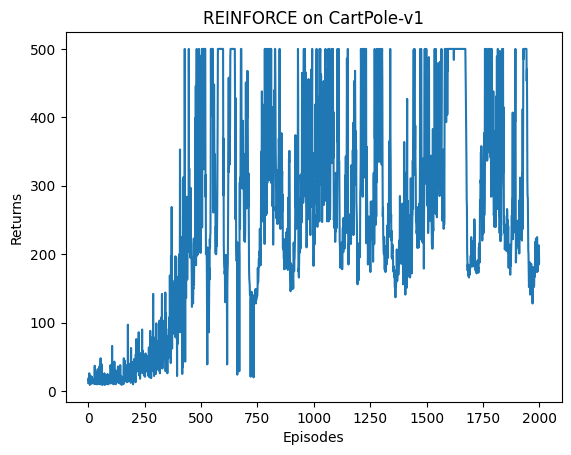

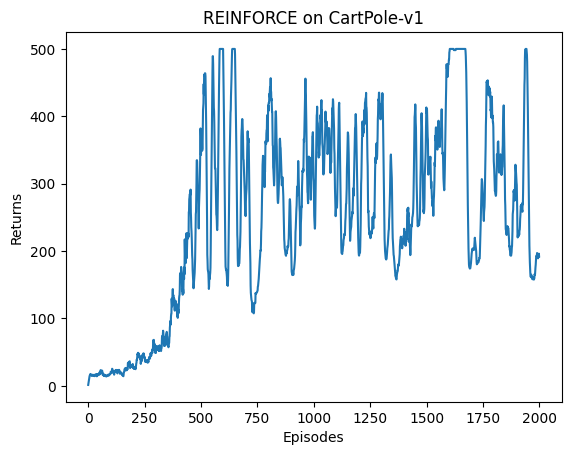

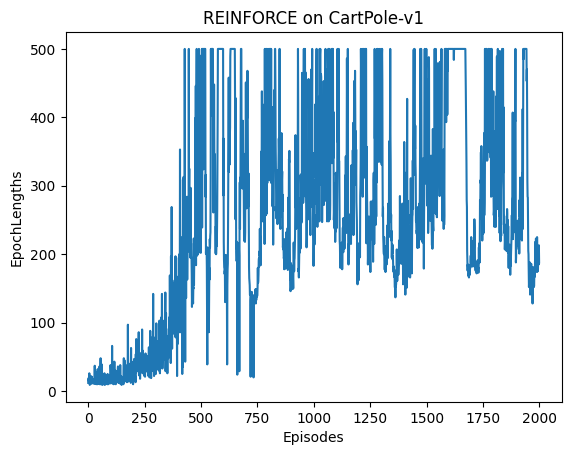

In [5]:
import matplotlib.pyplot as plt
env_name = "CartPole-v1"

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

def moving_average(targets, truncated_num) :
    truncated_sum = 0
    queue = []
    results = []
    for target in targets :
        queue.append(target)
        truncated_sum += target
        results.append(truncated_sum / truncated_num)
        if len(queue) == truncated_num :
            truncated_sum -= queue.pop(0)
            
    return results

mv_return = moving_average(return_list, 9)
#print(return_list, mv_return)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

episodes_list = list(range(len(epoch_length_list)))
plt.plot(episodes_list, epoch_length_list)
plt.xlabel('Episodes')
plt.ylabel('EpochLengths')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

为什么actor可以用代理目标，critic不可以？  
因为actor的目标是累积折扣奖励，是一个真实的目标，可以通过构造代理目标逼近真实目标。  
而critic实际上没有目标，critic实际上是在解固定策略下的贝尔曼方程。td error不是要最小化的目标，构造的目的只是通过最小化的方式让状态价值迭代到不动点。所以不能用类似actor的方式去构造一个代理目标引导$w$做梯度上升，这会导致无法收敛到不动点。  

想起来了，TD法是在随机梯度下降算法之后，是通过随机梯度下降来解贝尔曼方程的方法。同章的策略提升部分直接用的贪心策略。  